$$
  -\Delta u(x,y) \;=\; f(x,y),
  \qquad (x,y)\in[a,a+L]\times[b,b+L],
$$
$$
a=-1,\quad b=-1,\quad L=2
$$
$$
  u(x,y) = u_E(x,y) \quad\text{en las fronteras } x=a\ \cup\ y=b+L,
  \quad u_E(x,y) = \sin(\pi x)\cos(\pi y).
$$
$$
  \frac{\partial u}{\partial n}(x,y) = q_E(y)\quad\text{en } x=a+L,
  \qquad
  \frac{\partial u}{\partial n}(x,y) = q_S(x)\quad\text{en } y=b,
$$
$$
  q_E(y) = \pi\cos\bigl(\pi(a+L)\bigr)\cos(\pi y),
  \qquad
  q_S(x) = \pi\sin(\pi x)\sin\bigl(\pi b\bigr).
$$
$$
  f(x,y) = 2\pi^2\,\sin(\pi x)\cos(\pi y).
$$

In [1]:
# =============
# CARGA DE LIBRERIAS

import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

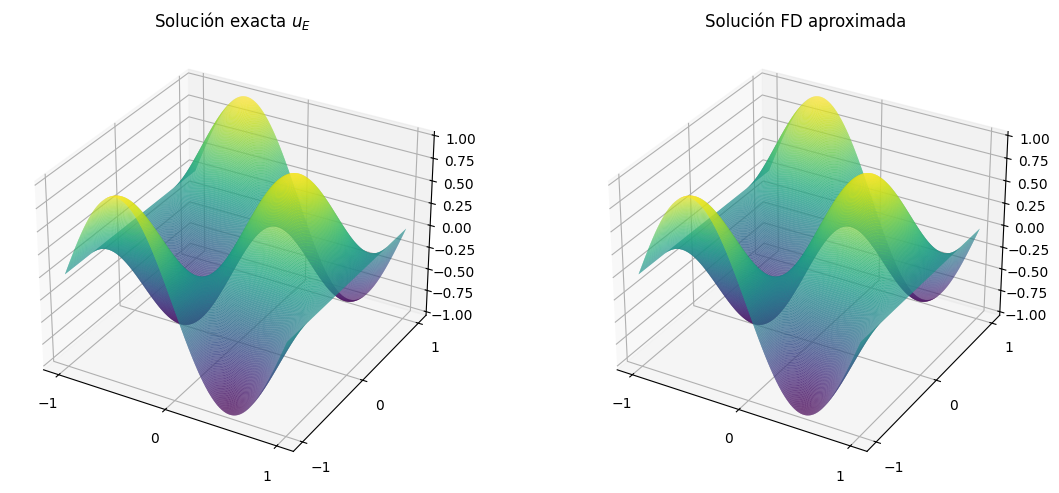

In [2]:
# RESOLUCION MEDIANTE MDF

# Parametros del dominio y malla
a, b, L = -1.0, -1.0, 2.0
N = 999                     # N+1 subdivisiones por lado
h = L / (N + 1)             # paso uniforme
x = np.linspace(a, a+L, N+2)
y = np.linspace(b, b+L, N+2)
X, Y = np.meshgrid(x, y, indexing='ij')  # malla 2D

# Funciones analiticas
def uE(x, y):
    return np.sin(np.pi * x) * np.cos(np.pi * y)

def f_source(x, y):
    return 2 * (np.pi**2) * np.sin(np.pi * x) * np.cos(np.pi * y)

def qE(y):
    return np.pi * np.cos(np.pi*(a+L)) * np.cos(np.pi * y)

def qS(x):
    return np.pi * np.sin(np.pi * x) * np.sin(np.pi * b)

# Indices de frontera
xx = X.ravel()
yy = Y.ravel()
nfO = np.where(np.isclose(xx, a))[0]       # oeste (Dirichlet)
nfE = np.where(np.isclose(xx, a+L))[0]     # este (Neumann)
nfS = np.where(np.isclose(yy, b))[0]       # sur (Neumann)
nfN = np.where(np.isclose(yy, b+L))[0]     # norte (Dirichlet)
nfD = np.union1d(nfN, nfO)                 # Dirichlet combinado

# Vector independiente con penalizacion y Neumann
fV = f_source(xx, yy)
fV[nfE] += 2 * qE(yy[nfE]) / h
fV[nfS] += 2 * qS(xx[nfS]) / h
fV[nfD] = uE(xx[nfD], yy[nfD]) * 1e16

# Construccion de la matriz dispersa A
I = sparse.eye(N+2)
E = diags(np.ones(N+1), -1)
D = (2*I - E - E.T).tolil()
D[0,1]   = -2   # ajuste en frontera para Neumann
D[N+1,N] = -2
D = D.tocsr()
A = (sparse.kron(D, I) + sparse.kron(I, D)) / h**2

# Penalizacion Dirichlet en la diagonal
diagA = A.diagonal().copy()
diagA[nfD] = 1e16
A.setdiag(diagA)

# Resolucion y reconstruccion
sol = spsolve(A.tocsc(), fV)
uA = sol.reshape((N+2, N+2))

# Visualizacion 3D
xticks = [a, a + L/2, a + L]
yticks = [b, b + L/2, b + L]

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax1.plot_surface(X, Y, uE(X,Y), cmap='viridis', rstride=3, cstride=3)
ax1.set_title('Solución exacta $u_E$')
ax1.set_xticks(xticks); ax1.set_yticks(yticks)

ax2 = fig.add_subplot(1,2,2, projection='3d')
ax2.plot_surface(X, Y, uA, cmap='viridis', rstride=3, cstride=3)
ax2.set_title('Solución FD aproximada')
ax2.set_xticks(xticks); ax2.set_yticks(yticks)

plt.tight_layout()
plt.show()